In [0]:
import numpy as np
import pandas as pd
import math
from pathlib import Path
from torch.optim.lr_scheduler import OneCycleLR
import os
import random
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms
from fastprogress import master_bar, progress_bar
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data.sampler import Sampler
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import PIL


In [0]:
from pyronear.datasets.wildfire.wildfireSubSampler import SubSamplerDataset,WildFireSplitter
from pyronear.datasets.wildfire import FireLabeler
from pyronear.datasets.wildfire.split_strategy import *

In [0]:
torch.cuda.empty_cache()

In [0]:
# os.chdir("git/PyroNear")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
  import os
os.chdir("drive/My Drive/DeepLearning/Pyronear/git/PyroNear")
!ls

CONTRIBUTING.md  README.md	   TrainWildFire.ipynb
CreateDS.ipynb	 references	   TrainWildFire_SubSampler.ipynb
docs		 requirements.txt  TrainWildFire_SubSampler_K2.ipynb
LICENSE		 setup.py
pyronear	 test


In [4]:
os.chdir("..")
os.chdir("..")
!ls


 Clean_checkedLabels.ipynb   git			   TrainModelToy.ipynb
 CreateDataset.ipynb	     PR				   TrainOldDS.ipynb
 customDSTest.ipynb	    'TrainFastAi[Conflit].ipynb'   TrainOldDSToy.ipynb
 DB			     TrainFastAi.ipynb		   TrainWild.ipynb
 dfToy.csv		     TrainFGLoop2.ipynb		   videoanalysis
 dfToyEasy.csv		     TrainFGLoop_bce.ipynb	   WF.csv
 dict2.txt		     TrainFGLoop.ipynb		   wildfire.csv
 dict_Old.txt		     TrainFGLoop_old.ipynb	   WildfireDS.csv
 dict.txt		     TrainFGLoop_oldToy.ipynb	  'WildFire DS.ipynb'
 dict_wild.txt		    'TrainModel[Conflit].ipynb'
 GetFrame.ipynb		     TrainModel.ipynb


In [275]:
path_to_frames=Path("DB/Wildfire")
metadata=pd.read_csv("DB/Wildfire/metadata2.csv")
metadata=metadata[metadata['clf_confidence']==True]
metadata=metadata[metadata['exploitable']==True]
metadata=metadata[['exploitable', 'fire', 'sequence',
       'clf_confidence', 'loc_confidence', 'x', 'y', 't', 'stateStart',
       'stateEnd', 'frame', 'imgFile', 'fire_id', 'fBase']]
metadata

,exploitable,fire,sequence,clf_confidence,loc_confidence,x,y,t,stateStart,stateEnd,frame,imgFile,fire_id,fBase
0,True,True,0,True,True,742.268,417.155,0.005,0.0,151.0,14,108_frame14.png,20,108
1,True,True,0,True,True,742.268,417.155,0.005,0.0,151.0,71,108_frame71.png,20,108
2,True,True,0,True,True,742.268,417.155,0.005,0.0,151.0,92,108_frame92.png,20,108
3,True,True,0,True,True,742.268,417.155,0.005,0.0,151.0,102,108_frame102.png,20,108
4,True,True,0,True,True,742.268,417.155,0.005,0.0,151.0,106,108_frame106.png,20,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10810,True,False,0,True,True,353.110,389.282,1.484,37.0,1328.0,897,758_frame897.png,100,758
10811,True,False,0,True,True,353.110,389.282,1.484,37.0,1328.0,1081,758_frame1081.png,100,758
10812,True,False,0,True,True,353.110,389.282,1.484,37.0,1328.0,1132,758_frame1132.png,100,758
10813,True,False,0,True,True,353.110,389.282,1.484,37.0,1328.0,1163,758_frame1163.png,100,758


In [0]:
# #subset
# metadata=metadata[0:int(len(metadata)/5)]

In [276]:
#equalize dataset
ratio=len(metadata[metadata['fire']==True])/len(metadata[metadata['fire']==False])
ratio

2.0944741532976825

In [0]:
metadata.loc[metadata['fire']==True,'fire']=1
metadata.loc[metadata['fire']==False,'fire']=0

In [278]:
ratio=len(metadata[metadata['fire']==1])/len(metadata[metadata['fire']==0])
ratio

2.0944741532976825

In [279]:
meta=metadata[['exploitable', 'fire', 'sequence',
       'clf_confidence', 'loc_confidence', 'x', 'y', 't', 'stateStart',
       'stateEnd', 'fire_id', 'fBase']]
meta=meta.drop_duplicates()
meta['seq']=np.arange(len(meta))
metadata=pd.merge(metadata, meta, on=['exploitable', 'fire', 'sequence',
       'clf_confidence', 'loc_confidence', 'x', 'y', 't', 'stateStart',
       'stateEnd', 'fire_id', 'fBase'], how='inner')

metadata


,exploitable,fire,sequence,clf_confidence,loc_confidence,x,y,t,stateStart,stateEnd,frame,imgFile,fire_id,fBase,seq
0,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,14,108_frame14.png,20,108,0
1,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,71,108_frame71.png,20,108,0
2,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,92,108_frame92.png,20,108,0
3,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,102,108_frame102.png,20,108,0
4,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,106,108_frame106.png,20,108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,True,0,0,True,True,353.110,389.282,1.484,37.0,1328.0,897,758_frame897.png,100,758,1569
8676,True,0,0,True,True,353.110,389.282,1.484,37.0,1328.0,1081,758_frame1081.png,100,758,1569
8677,True,0,0,True,True,353.110,389.282,1.484,37.0,1328.0,1132,758_frame1132.png,100,758,1569
8678,True,0,0,True,True,353.110,389.282,1.484,37.0,1328.0,1163,758_frame1163.png,100,758,1569


In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
    normalize
])

test_transforms = transforms.Compose([
    transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
   normalize
])

tf={'train':train_transforms,'test':train_transforms,'val':train_transforms}

In [0]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop((224,224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     normalize
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     normalize
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#    normalize
# ])

# tf={'train':train_transforms,'test':train_transforms,'val':train_transforms}

In [0]:
K=3

In [0]:
wildfire = SubSamplerDataset(metadata=metadata,path_to_frames=path_to_frames,frame_per_seq=K,target_names=['fire'])

In [0]:
BATCH_SIZE=10*K
wildfire.computeSubSet(BATCH_SIZE)


In [285]:
ratios = {'train': 0.78, 'val': 0.2, 'test':0.02}

splitter =  WildFireSplitter(ratios, transforms=tf)
splitter.fit(wildfire,BATCH_SIZE)
print(splitter.n_samples_)

train_loader = DataLoader(splitter.train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(splitter.val, batch_size=BATCH_SIZE, shuffle=False)
test_loader= DataLoader(splitter.test, batch_size=BATCH_SIZE, shuffle=False)

/content/drive/My Drive/DeepLearning/Pyronear/git/PyroNear/pyronear/datasets/wildfire/wildfireSubSampler.py:181: Warning: Inconsistent Fire Labeling. Maybe try to label the fire again
Distinct values of ids(302 ≠ 420)
  f" ≠ {wildfire.metadata['fire_id'].max() + 1})", Warning)


{'train': 2430, 'val': 630, 'test': 0}


In [0]:
def set_seed(seed):
    """Set the seed for pseudo-random number generations
    Args:
        seed (int): seed to set for reproducibility
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def train_batch(model, x, target, optimizer, criterion):
    """Train a model for one iteration
    Args:
        model (torch.nn.Module): model to train
        loader_iter (iter(torch.utils.data.DataLoader)): training dataloader iterator
        optimizer (torch.optim.Optimizer): parameter optimizer
        criterion (torch.nn.Module): criterion object
    Returns:
        batch_loss (float): training loss
    """

    # Forward
    outputs = model(x)

    # Loss computation
    # target=target[::model.K]
    batch_loss = criterion(outputs, target)

    # Backprop
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    return batch_loss.item()


def train_epoch(model, train_loader, optimizer, criterion, master_bar,
                epoch=0, scheduler=None, device='cpu'):
    """Train a model for one epoch
    Args:
        model (torch.nn.Module): model to train
        train_loader (torch.utils.data.DataLoader): training dataloader
        optimizer (torch.optim.Optimizer): parameter optimizer
        criterion (torch.nn.Module): criterion object
        master_bar (fastprogress.MasterBar): master bar of training progress
        epoch (int): current epoch index
        scheduler (torch.optim._LRScheduler, optional): learning rate scheduler
        device (str): device hosting tensor data
    Returns:
        batch_loss (float): latch batch loss
    """

    # Training
    model.train()
    loader_iter = iter(train_loader)
    train_loss = 0
    for _ in progress_bar(range(len(train_loader)), parent=master_bar):

        x, target = next(loader_iter)
        x, target = x.cuda(), target.type(torch.LongTensor).squeeze().cuda()

        batch_loss = train_batch(model, x, target, optimizer, criterion)
        train_loss += batch_loss
        if scheduler:
            scheduler.step()

        master_bar.child.comment = f"Batch loss: {batch_loss:.4}"

    train_loss /= len(train_loader)

    return train_loss


def evaluate(model, test_loader, criterion, device='cpu'):
    """Evaluation a model on a dataloader
    Args:
        model (torch.nn.Module): model to train
        train_loader (torch.utils.data.DataLoader): validation dataloader
        criterion (torch.nn.Module): criterion object
        device (str): device hosting tensor data
    Returns:
        val_loss (float): validation loss
        acc (float): top1 accuracy
    """
    model.eval()
    val_loss, correct, targets = 0, 0, 0
    with torch.no_grad():
        for x, target in test_loader:
            # Work with tensors on GPU
            #if device.startswith('cuda'):
            # target=target[::model.K]
            x, target = x.cuda(), target.type(torch.LongTensor).squeeze().cuda()

            # Forward + Backward & optimize
            outputs = model.forward(x)
            val_loss += criterion(outputs, target).item()
            # Index of max log-probability
            pred = outputs.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            targets += x.size(0)
    val_loss /= len(test_loader)
    acc = correct / targets

    return val_loss, acc

In [0]:

import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

class MyResNet18(ResNet):
    def __init__(self,bs,K):
        super(MyResNet18, self).__init__(BasicBlock, [2, 2, 2, 2])
        self.bs=bs
        self.K=K
        self.fc1 = nn.Linear(int(512*self.K), 32)
        self.fc2 = nn.Linear(32, 2)
        #self.fc = nn.Linear(int(512*self.K), 1)
    def forward(self, x):
        bs=x.shape[0]
        # change forward here
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
      
        x = x.view(int(bs/self.K) ,int(512*self.K))
       
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        x2=torch.cat([x,x,x])
        x2[::self.K]=x
        x2[1::self.K]=x
        x2[2::self.K]=x

        
       

        return x2


model = MyResNet18(K*BATCH_SIZE,K)
# if you need pretrained weights
# if you need pretrained weights
dictres18=models.resnet18(pretrained=True).state_dict()
dictres18['fc1.weight']=torch.rand(32,512*K)
dictres18['fc1.bias']=0*torch.rand(32)
dictres18['fc2.weight']=torch.rand(2,32)
dictres18['fc2.bias']=0*torch.rand(2)
# #dictres18=torch.load("dict_Old.txt")
# fc1w=dictres18['fc1.weight']
# fc2w=dictres18['fc2.weight']
# for k in range(1,K):
#   dictres18['fc1.weight']=torch.cat((dictres18['fc1.weight'], fc1w), 1)

# #dictres18['fc1.weight']/=K

# dictres18=models.resnet18(pretrained=True).state_dict()
# dictres18['fc.weight']=torch.rand(1,512*K)
# dictres18['fc.bias']=0*torch.rand(1)

model.load_state_dict(dictres18)

model.fc1.weight=torch.nn.init.xavier_uniform_(model.fc1.weight)
model.fc2.weight=torch.nn.init.xavier_uniform_(model.fc2.weight)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model = model.to(device)

In [0]:
epochs=10

lr=0.001
weight_decay=0.001

# optimizer

optimizer = optim.Adam(model.parameters(),lr=lr, betas=(0.9, 0.99), weight_decay=weight_decay)

# Loss function
#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

# Scheduler
lr_scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs, steps_per_epoch=len(train_loader),cycle_momentum=(not isinstance(optimizer, optim.Adam)))
#lr_scheduler =None

In [0]:
#train FC
for param in model.parameters():
    param.requires_grad = False
model.fc1.weight.requires_grad = True
model.fc2.bias.requires_grad = True
model.fc2.weight.requires_grad = True
model.fc2.bias.requires_grad = True

In [292]:
best_loss = math.inf
mb = master_bar(range(epochs))
for epoch_idx in mb:
    # Training
    train_loader.dataset.computeSubSet(BATCH_SIZE)
    # train_loader  = data.DataLoader(dsTrain, batch_size=K*BATCH_SIZE, shuffle=False) 

    train_loss=train_epoch(model, train_loader, optimizer, criterion, master_bar=mb, epoch=epoch_idx, scheduler=lr_scheduler, device=device)

    # Evaluation
    val_loss, acc = evaluate(model, val_loader, criterion, device=device)

    mb.comment = f"Epoch {epoch_idx+1}/{epochs}"
    mb.write(f'Epoch {epoch_idx+1}/{epochs} - Training loss: {train_loss:.4} | Validation loss: {val_loss:.4} | Error rate: {1 - acc:.4}')

    # State saving
    if val_loss < best_loss:
        print(f"Validation loss decreased {best_loss:.4} --> {val_loss:.4}: saving state...")
        best_loss = val_loss
        torch.save(model.state_dict(), "model.txt")
      

Validation loss decreased inf --> 0.6491: saving state...
Validation loss decreased 0.6491 --> 0.5521: saving state...
Validation loss decreased 0.5521 --> 0.5395: saving state...
Validation loss decreased 0.5395 --> 0.4945: saving state...
Validation loss decreased 0.4945 --> 0.4722: saving state...
Validation loss decreased 0.4722 --> 0.4693: saving state...
Validation loss decreased 0.4693 --> 0.4648: saving state...


In [0]:
#train ALL
for param in model.parameters():
    param.requires_grad = True
epochs=6
lr/=10
optimizer = optim.Adam(model.parameters(),lr=lr, betas=(0.9, 0.99), weight_decay=weight_decay)
lr_scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs, steps_per_epoch=len(train_loader),cycle_momentum=(not isinstance(optimizer, optim.Adam)))
#lr_scheduler =None

In [294]:

mb = master_bar(range(epochs))
for epoch_idx in mb:
    # Training
    train_loader.dataset.computeSubSet(BATCH_SIZE)
    # dsTrain.computeSubSet(BATCH_SIZE,dfTrain)
    # train_loader  = data.DataLoader(dsTrain, batch_size=K*BATCH_SIZE, shuffle=False) 

    train_loss=train_epoch(model, train_loader, optimizer, criterion, master_bar=mb, epoch=epoch_idx, scheduler=lr_scheduler, device=device)

    # Evaluation
    val_loss, acc = evaluate(model, val_loader, criterion, device=device)

    mb.comment = f"Epoch {epoch_idx+1}/{epochs}"
    mb.write(f'Epoch {epoch_idx+1}/{epochs} - Training loss: {train_loss:.4} | Validation loss: {val_loss:.4} | Error rate: {1 - acc:.4}')

    # State saving
    if val_loss < best_loss:
        print(f"Validation loss decreased {best_loss:.4} --> {val_loss:.4}: saving state...")
        best_loss = val_loss
        torch.save(model.state_dict(), "model.txt")
      

Validation loss decreased 0.4648 --> 0.4193: saving state...
Validation loss decreased 0.4193 --> 0.3901: saving state...
Validation loss decreased 0.3901 --> 0.3507: saving state...


UnboundLocalError: ignored

In [0]:
torch.save(model.state_dict(), "model_K3_V2.txt")

In [0]:
model2 = MyResNet18(K*BATCH_SIZE,K)
model2.load_state_dict("model.txt")

In [0]:
t1=0
t2=0
for x, target in train_loader:
     t1+=(target==False).sum()
     t2+=(target==True).sum()

In [0]:
print(t1,t2)

tensor(860) tensor(932)


In [0]:
100/192

0.5208333333333334

In [0]:
model=model.eval()
X=torch.tensor([])
Y=torch.tensor([])
R=torch.tensor([])
for x, target in train_loader:
    x, target = x.cuda(), target.type(torch.LongTensor).squeeze().cuda()

    # Forward
    outputs = model(x)
    # target=target[::model.K]

    # Loss computation
    pred = outputs.max(1, keepdim=True)[1]
  
    y=pred.t()==target
    X = torch.cat([X,x[y.squeeze()==False,:,:,:].cpu()])
    Y = torch.cat([Y,target[y.squeeze()==False].cpu().float()])
    R = torch.cat([R,y.squeeze().cpu().float()])

  
   

In [192]:
R.shape

torch.Size([2700])

In [297]:
meta=train_loader.dataset.metadata
meta[:20]

,exploitable,fire,sequence,clf_confidence,loc_confidence,x,y,t,stateStart,stateEnd,frame,imgFile,fire_id,fBase,seq
0,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,14,108_frame14.png,20,108,0
1,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,71,108_frame71.png,20,108,0
2,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,92,108_frame92.png,20,108,0
3,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,102,108_frame102.png,20,108,0
4,True,1,0,True,True,742.268,417.155,0.005,0.0,151.0,106,108_frame106.png,20,108,0
5,True,1,0,True,2,817.237,496.577,3.683,197.0,1500.0,1057,110_frame1057.png,171,110,1
6,True,1,0,True,2,817.237,496.577,3.683,197.0,1500.0,1292,110_frame1292.png,171,110,1
7,True,1,0,True,2,817.237,496.577,3.683,197.0,1500.0,1323,110_frame1323.png,171,110,1
8,True,1,0,True,2,817.237,496.577,3.683,197.0,1500.0,1327,110_frame1327.png,171,110,1
9,True,1,0,True,2,817.237,496.577,3.683,197.0,1500.0,1491,110_frame1491.png,171,110,1


In [320]:
imgs=train_loader.dataset.SubSetImgs
imgs=[im for i,im in enumerate(imgs) if R[i] ==0]
imgs[40]

'179_frame494.png'

In [299]:
tt=[im for r in np.array(R) if r ==0]
len(tt)

117

In [269]:
R=np.array(R)
R

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [319]:
meta[meta['fBase']==708]

,exploitable,fire,sequence,clf_confidence,loc_confidence,x,y,t,stateStart,stateEnd,frame,imgFile,fire_id,fBase,seq
2645,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,19,708_frame19.png,87,708,576
2646,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,56,708_frame56.png,87,708,576
2647,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,97,708_frame97.png,87,708,576
2648,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,107,708_frame107.png,87,708,576
2649,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,111,708_frame111.png,87,708,576
2650,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,19,708_frame19.png,87,708,576
2651,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,56,708_frame56.png,87,708,576
2652,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,97,708_frame97.png,87,708,576
2653,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,107,708_frame107.png,87,708,576
2654,True,1,0,True,2,735.446,478.812,0.209,5.0,128.0,111,708_frame111.png,87,708,576


In [207]:
(np.array(R.int())==0).sum()

171

In [0]:
x=X*0.229+0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1.]])


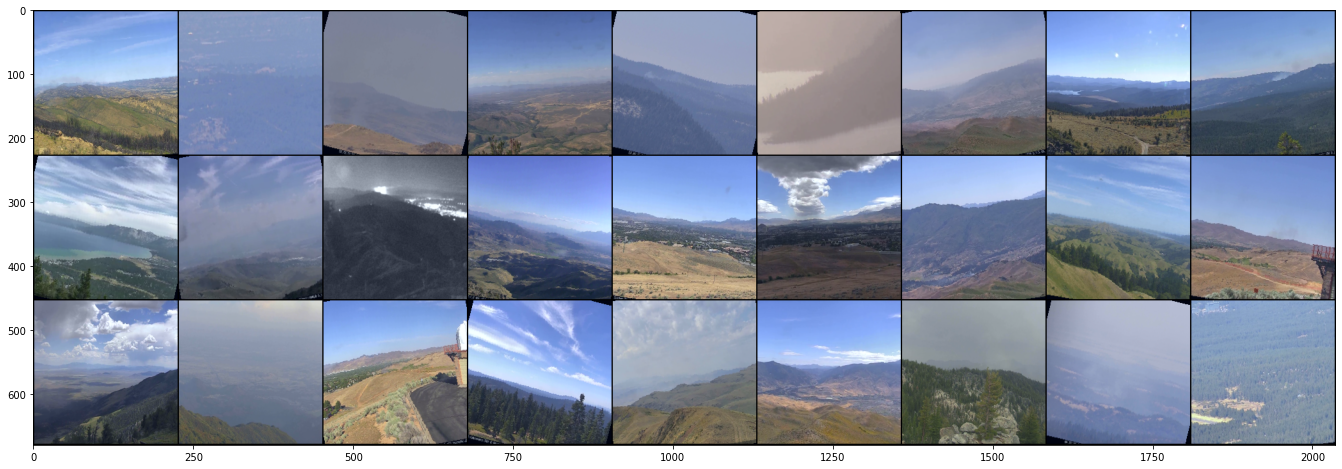

In [302]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

im = make_grid(x[:80:3,:,:,:], nrow=9)
plt.figure(figsize=(12*2,4*2))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
print(Y[:80:3].view(-1,9))

In [0]:
import cv2

In [0]:
model.fc1.weight

Parameter containing:
tensor([[-0.0688,  0.0635,  0.0232,  ..., -0.0070,  0.0458, -0.0764],
        [-0.0014, -0.0772, -0.0105,  ...,  0.0589,  0.0600,  0.0540],
        [-0.0275, -0.0373,  0.0378,  ..., -0.0139, -0.0260,  0.0557],
        ...,
        [ 0.0313, -0.0525,  0.0263,  ...,  0.0076, -0.0672, -0.0391],
        [-0.0272,  0.0495,  0.0002,  ..., -0.0413, -0.0650, -0.0079],
        [-0.0452,  0.0485,  0.0468,  ..., -0.0575, -0.0160, -0.0293]],
       device='cuda:0', requires_grad=True)

In [0]:
y = model(1000*x)

In [304]:
DB=x.permute(2,3,1,0)
DB.shape

torch.Size([224, 224, 3, 117])

In [154]:
cv2.imwrite('test.png',DB[:,:,:,1])

TypeError: ignored

In [156]:
cv2.imwrite("test.png",np.array(DB[:,:,:,0]))


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


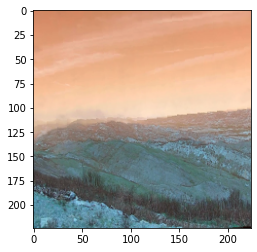

In [314]:
import matplotlib.pyplot as plt 
im=DB[:,:,:,0]
im=np.array(im)
im=im[:,:,[2, 1,0]]
plt.imshow(im)

In [316]:
im2=cv2.resize(im,(448,448))
im2.shape

(448, 448, 3)

In [179]:
i=1
n="%04d" % i
cv2.imwrite("bugs//im_"+n+"_"+str(int(np.array(Y[i])))+".png",255*im)

True

In [178]:
str(int(np.array(Y[i])))

'1'

In [0]:
for i in range(117):
  im=DB[:,:,:,i]
  im=np.array(im)
  im=im[:,:,[2, 1,0]]
  im=cv2.resize(im,(448,448))
  n="%04d" % i
  cv2.imwrite("bugs//im_"+n+"_"+str(int(np.array(Y[i])))+".png",255*im)


In [0]:
files=train_loader.dataset.imgs
files=files[]